<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_pytorch_DL/blob/main/20220926_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 살펴보기
 - 뉴욕 타임스 코멘트 데이터 사용

In [2]:
import pandas as pd
import os
import string

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/CH10/ArticlesApril2017.csv")
print(df.columns)

Index(['abstract', 'articleID', 'articleWordCount', 'byline', 'documentType',
       'headline', 'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


 - headline : 사람이 직접 작성한 기사

In [3]:
df['headline'][0]

'Finding an Expansive View  of a Forgotten People in Niger'

In [4]:
df['headline'].shape # 886개의 헤드라인

(886,)

In [5]:
type(df.headline.values)

numpy.ndarray

## 학습용 데이터 만들기
 - 1. 구두점, 특수문자 제거
 - 2. 단어마다 고유번호 사전(BOW)
 - 3. 자연어 문장속 단어들을 고유번호로 바꿔 새로운 문장생성
 - 4. 두개의 단어와 다음에 올 단어를 반환하도록 데이터셋 객체 생성

In [6]:
import numpy as np
import glob

from torch.utils.data.dataset import Dataset

# 학습에 사용할 데이터셋 객체 정의
class TextGeneration(Dataset):
    # 텍스트 → 소문자, 특수문자 제거하는 함수
    def clean_text(self, txt): # txt로 받을것 : 기사문자열
        txt = "".join(v for v in txt if v not in string.punctuation) # 리스트에 들어있는 특수문자를 빈공백으로 만듦
        # string.punctuation : 특수문자모아놓은 리스트
        txt = txt.lower()
        return txt
    
    def  __init__(self):
        all_headlines = []

        # 모든 헤드라인의 텍스트를 불러옴
        for filename in glob.glob("/content/drive/MyDrive/Colab Notebooks/data/CH10/*.csv"):
            if 'Articles' in filename: # 기사에 해당되는 파일만 선별해서 df으로
                article_df = pd.read_csv(filename)
                
                # 데이터셋의 headline값을 all_headlines에 추가
                all_headlines.extend(list(article_df['headline'].values)) # .values : array
                # list.extend(iterable) : iterable객체(그대로가 아닌) 요소들을 list에 넣는다
                break

        # headline중 Unknown값 제거
        all_headlines = [h for h in all_headlines if h!= "Unknown"]

        # 구두점 제거 및 전처리가 된 문장들을 리스트로 반환
        self.corpus = [self.clean_text(x) for x in all_headlines] # 1214개의 기사 각각을 꺼내 전처리하여 다시 리스트화
        self.BOW = {} # {"단어" : 고유숫자}

        # 모든 문장의 단어를 추출해 고유 번호 지정
        for line in self.corpus: # line : 전처리된 각 헤드라인 문장
            for word in line.split(): # word : 단어 단위
                if word not in self.BOW.keys():
                    self.BOW[word] = len(self.BOW.keys())
        
        # 모델의 입력으로 사용할 데이터
        self.data = self.generate_sequence(self.corpus)

    def generate_sequence(self,txt):
        seq = []

        for line in txt:
            line = line.split()
            line_bow = [self.BOW[word] for word in line]

            # 단어 2개를 입력으로, 그다음 단어를 정답으로갖는 세개의 단어 데이터 세트
            # [([단어1, 단어2], 단어3), ([단어2, 단어3], 단어4), ...]
            data = [([line_bow[i], line_bow[i+1]], line_bow[i+2]) for i in range(len(line_bow)-2)]

            seq.extend(data)
        
        return seq
    
    def __len__(self):
        return len(self.data) # self.data는 seq와 같음
        
    def __getitem__(self, i):
        data = np.array(self.data[i][0]) # 입력데이터
        label = np.array(self.data[i][1]).astype(np.float32) # 출력데이터

        return data, label

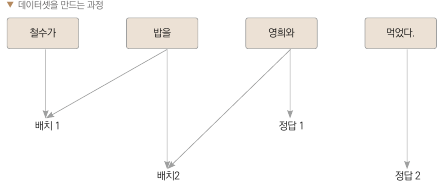

## LSTM 모델 정의하기
 - BOW를 그대로 입력으로 사용하지 않고,
 - 희소표현벡터를 사용 : 대부분의 값이 0이므로 원활한 학습 안됨
 - 임베딩층 필요 : 희소표현인 입력벡터를 밀집표현으로 바꿔주는 층

  > 파이토치의 임베딩층 이용 : nn.Embedding()

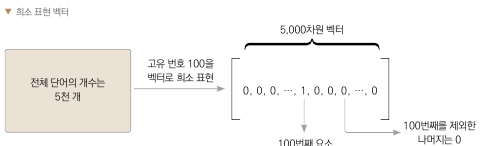

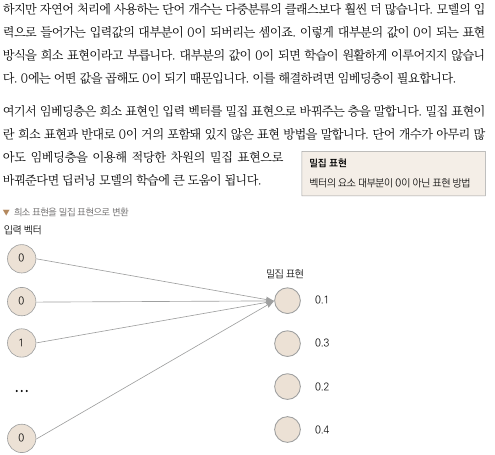

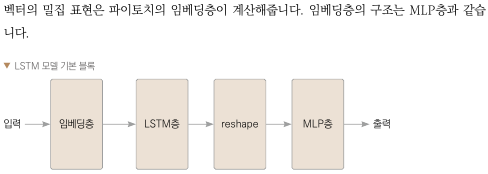

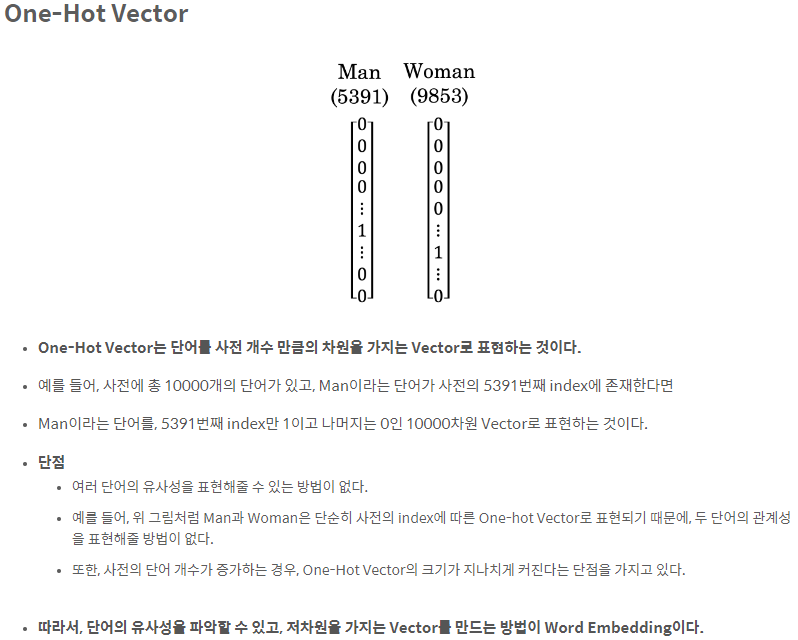

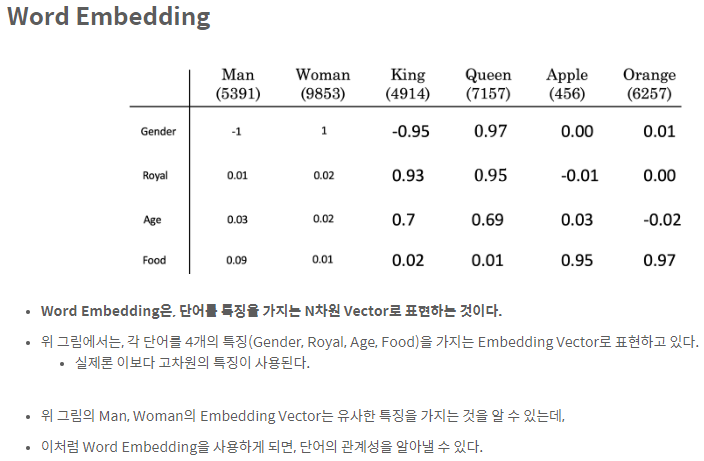

In [7]:
# LSTM 모델 정의
import torch.nn as nn
import torch

class LSTM(nn.Module):
    def __init__(self, num_embeddings):
        super().__init__()

        # 밀집 표현을 위한 임베딩층
        self.embed = nn.Embedding(num_embeddings=num_embeddings,
                                  embedding_dim=16) # num_embeddings차원(BOW의 단어개수)의 벡터를 embedding_dim차원으로 변경
        # LSTM을 5개 층으로 쌓음
        self.lstm = nn.LSTM(input_size=16,
                            hidden_size=64,
                            num_layers=5,
                            batch_first=True)
        
        # 분류를 위한 MLP층
        self.fc1 = nn.Linear(128, num_embeddings)
        self.fc2 = nn.Linear(num_embeddings, num_embeddings)

        # 활성화 함수
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embed(x)

        # LSTM모델의 예측값
        x, _ = self.lstm(x) # 전체출력, 마지막 은닉상태 반환
        x = torch.reshape(x, (x.shape[0], -1))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

## 학습하기
 - 뒤에 올 단어를 분류하는 분류 문제
 - 손실계산에 크로스 엔트로피 함수 이용

In [8]:
# 모델 학습하기
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

# 프로세서 정의
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = TextGeneration() # 데이터셋 정의
model = LSTM(num_embeddings=len(dataset.BOW)) # 모델 정의
model = model.to(device)
loader = DataLoader(dataset, batch_size=64) # 데이터로더 정의
optim = Adam(model.parameters(), lr=0.001)  # 옵티마이저 정의

In [9]:
# for epoch in range(50):
#     iterator = tqdm.tqdm(loader)
#     for data, label in iterator:
#         data = torch.tensor(data, dtype=torch.long).to(device) # torch.tensor → 기본텐서(float64), torch.long → int64
#         label = torch.tensor(label, dtype=torch.long).to(device)

#         # 기울기 초기화
#         optim.zero_grad()

#         # 모델의 예측값
#         pred = model(data)

#         # 손실값
#         criterion = nn.CrossEntropyLoss()
#         loss = criterion(pred, label)

#         # 오차 역전파
#         loss.backward()
#         optim.step()

#         iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

# torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/lstm.pth')

## 모델 성능 평가하기
 - 인공지능이 쓴 문장을 확인하려면 반복적으로 모델을 사용해야함

In [10]:
# 모델이 예측하는 문장을 출력하는 함수

def generate(model, BOW, string='finding an', strlen=10):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'input word: {string}')

    with torch.no_grad():
        for p in range(strlen):
            # 입력 문장을 텐서로 변경
            words = [BOW[w] for w in string.split()] # 단어에 해당하는 정수로 리스트화
            words = torch.tensor(words, dtype=torch.long).to(device) # int64타입의 텐서화

            # 모델의 입력으로 사용하기 위한 배치 차원 추가(맨앞에)
            input_tensor = torch.unsqueeze(words[-2:], dim=0) # words[-2:] : 마지막 두단어만 사용
            output = model(input_tensor)
            print(output) # 
            print(output.shape) # 
            output_word = torch.argmax(output).cpu().numpy() # index
            print(output_word) # 
            print(output_word.shape) #
            string += list(BOW.keys())[output_word] # 문장에 예측된 단어를 추가
            string += " " # 단어를 추가하고 나면 띄워쓰기 추가
        
    print(f'predicted sentence : {string}')

In [11]:
model = LSTM(num_embeddings=len(dataset.BOW))
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/lstm.pth', map_location=device))

<All keys matched successfully>

In [12]:
generate(model, dataset.BOW)

input word: finding an
tensor([[-1.4185, -1.2210, -2.1988,  ..., -1.2577, -1.1773, -1.2259]])
torch.Size([1, 3619])
27
()


KeyError: ignored